In [1]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import glob
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

/Users/alyssa/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#grab wrangled data files
transcripts = glob.glob('../data/Trump/*.txt')

In [6]:
#separate into training/testing by fraction
trainFrac = int(len(transcripts)*0.80)

#random.shuffle(transcripts)

training = transcripts[:trainFrac]
testing = transcripts[trainFrac:]

In [7]:
#get bag of words for each speech in training and
#testing datasets
training_speeches = []
for i in range(len(training)):
    speech = open(training[i],'r')
    words = []
    for line in speech:
        words += word_tokenize(line)
    seperator = ' '
    training_speeches.append(seperator.join(words))

testing_speeches = []
for i in range(len(testing)):
    speech = open(testing[i],'r')
    words = []
    for line in speech:
        words += word_tokenize(line)
    sperator = ' '
    testing_speeches.append(seperator.join(words))
    

In [8]:
#format bag of words
cv = CountVectorizer(analyzer = 'word', max_features = 50, lowercase=True, preprocessor=None, tokenizer=None, stop_words = 'english')  
training_vectors = cv.fit_transform(training_speeches)
testing_vectors = cv.fit_transform(testing_speeches)

training_classification = []
prediction = []

#cycle through k-means for 3-10 clusters
for k in range(2,12):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans_indices = kmeans.fit_predict(training_vectors)
    training_classification.append(kmeans_indices)
    predicted_indices = kmeans.predict(testing_vectors)
    prediction.append(predicted_indices)
 
    k += 1
    




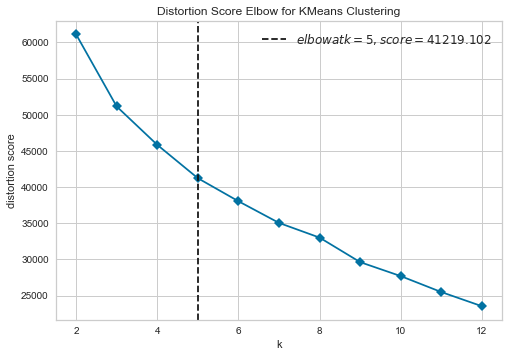

In [9]:
visualizer = KElbowVisualizer(kmeans,k=(2,13), timings=False)
visualizer.fit(training_vectors)
visualizer.show()

In [33]:
elbow = 5

#print(training_classification)
#print(predicted_indices)
#print(training_classification[elbow-2])
#print(prediction[elbow-2])

In [11]:
kmeans = KMeans(n_clusters = elbow, init = 'k-means++', random_state = 0)
kmeans_indices = kmeans.fit_predict(training_vectors)
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(elbow):
    print("Cluster %d: " % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0: 
 tremendous
 new
 years
 everybody
 world
 good
 going
 time
 states
 type
Cluster 1: 
 good
 got
 right
 years
 think
 everybody
 help
 opportunity
 school
 make
Cluster 2: 
 good
 think
 everybody
 got
 school
 right
 really
 let
 world
 make
Cluster 3: 
 good
 think
 today
 everybody
 got
 time
 school
 make
 right
 really
Cluster 4: 
 good
 years
 think
 everybody
 got
 make
 time
 let
 right
 really


# DOW JONES

In [39]:
dowjones = pd.read_csv('../dowjones/DJI.csv')
dowjones.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-11,17593.589844,17593.589844,17352.630859,17402.839844,17402.839844,103010000
1,2015-08-12,17382.929688,17423.900391,17125.810547,17402.509766,17402.509766,120400000
2,2015-08-13,17401.640625,17481.779297,17341.339844,17408.250000,17408.250000,88550000
3,2015-08-14,17410.119141,17492.900391,17394.060547,17477.400391,17477.400391,82120000
4,2015-08-17,17472.660156,17551.400391,17341.720703,17545.179688,17545.179688,73380000


In [40]:
dowjones.drop(columns=['Open','High','Low','Adj Close'],inplace=True)
dowjones['Date'] = pd.to_datetime(dowjones['Date'])

In [56]:
classified_clusters = kmeans_indices #+ prediction[elbow-2]
#predicted_clusters = kmeans.predict(testing_vectors)
speech_dates = training
#speech_dates = transcripts
dates = []
for i in range(len(speech_dates)):
    date_time_str = speech_dates[i][14:-4] #add spaces
    date_time_obj = datetime.datetime.strptime(date_time_str, '%B%d%Y')
    dates.append(date_time_obj)

[2 0 0 0 0 4 2 1 0 2 2 0 4 3 0 1 3 0 2 4 0 0 0 2 2 0 2 4 3 0 0 2 0 0 4 0 0
 0 0 2 3 0]


In [63]:
speeches = {'speech_date':dates, 'Cluster':classified_clusters, 'Close':np.zeros(len(dates))}
speeches_df = pd.DataFrame(data=speeches)

In [62]:
close = []
#match the dowjones 'close' to the date of speeches 
for i in range(len(speeches_df)):
    for j in range(len(dowjones)):
        if (dowjones['Date'].iloc[j] == speeches_df['speech_date'].iloc[i]):
            close.append([speeches_df['speech_date'].iloc[i],dowjones['Close'].iloc[j],speeches_df['Cluster'].iloc[i]])

In [65]:
new_df = pd.DataFrame(data=close,columns=['Date','Close','Cluster'])
new_df.head()

,Date,Close,Cluster
0,2020-01-08,28745.089844,0
1,2020-04-16,23537.679688,0
2,2019-08-05,25717.740234,0
3,2020-07-15,26870.099609,4
4,2020-06-26,25015.550781,2


In [66]:
regressor = LinearRegression()
X = new_df['Cluster'].values.reshape(-1,1)
y = new_df['Close'].values
regressor.fit(X,y)
pred_y = regressor.predict(X)
r2_score(y,pred_y)

0.020731161590806235